# Self-Supervised Learned Representations and Multiple-CNN Functional Model using all four e4 sensors and TWristAR data.
Original adaption from base_classifier.ipynb and ind_conv_ankle_hip_wrist.ipynb

This is intended to be the "next step up" classifier for the Fusion of Learned Representations work.   Specifically, it uses the updated TWRistAR loader to provide all combinations of the four channels from the four e4 wristband sensors.   The model has not been updated or tuned on this version.

This is intended to be an interactive Jupyter notebook and not a stand alone .py file as with some of the other load_data code.

Author:  [Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), [IMICS Lab](https://imics.wp.txstate.edu/), Texas State University, 2022

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

TODO:
* Update and tune the model - before going further need to refactor code - original end-to-end file did train and test.  Separate into training phase so model can be tuned without test info leaking into work.
* Perpherial Temp ptemp is really off.   Need to look at this more, suspect the batch size should be revisited and all signals need to be normalized at a minimum.
* Modularize the model so that the individual learned representation models can be imported.



# Imports

In [1]:
import os
import shutil
import time
from datetime import datetime
from datetime import date
from random import randrange # for plotting samples
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves
from tabulate import tabulate # for verbose tables, showing data
import tensorflow as tf
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
from tensorflow.keras.callbacks import EarlyStopping
#imports for computing and displaying output metrics
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import urllib.request # to get files from web w/o !wget

In [2]:
# Use specific GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "6"


In [3]:
#enter path to where the datasets can be found
my_path = './Data'

In [4]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def get_shapes(np_arr_list):
    """Returns text, each line is shape and dtype for numpy array in list
       example: print(get_shapes([X_train, X_test, y_train, y_test]))"""
    shapes = ""
    for i in np_arr_list:
        my_name = namestr(i,globals())
        shapes += (my_name[0] + " shape is " + str(i.shape) \
            + " data type is " + str(i.dtype) + "\n")
    return shapes

In [5]:
import urllib.request # to get files from web w/o !wget
urllib.request.urlretrieve("https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/e4_wristband_Nov2019/twristar_load_dataset.py", filename="twristar_load_dataset.py")
urllib.request.urlretrieve("https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/e4_wristband_Nov2019/ue4w_load_dataset.py", filename="ue4w_load_dataset.py")
from twristar_load_dataset import twristar_load_dataset
t_names = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
channels_list = ['accel_x', 'accel_y', 'accel_z', 'accel_ttl','bvp','eda', 'p_temp'] # all channels to be used
x_train, y_train, x_valid, y_valid, x_test, y_test \
                                = twristar_load_dataset(
                                    incl_val_group = True,
                                    one_hot_encode = False,
                                    keep_channel_list = channels_list)
print("Labeled TWristAR Dataset ndarray shapes:")
print(" X      y")
print("train",x_train.shape, y_train.shape)  
print("valid",x_valid.shape, y_valid.shape)
print("test ",x_test.shape, y_test.shape)                          
# from ue4w_load_dataset import ue4w_load_dataset
# unlabeled_X, _, _, ch_list = ue4w_load_dataset()

x_unlabeled = np.load(my_path+'/HAR/e4_unlabeled.npy').astype(np.float32)
print("Shape x_unlabeled",x_unlabeled.shape)

x_labeled = np.load(my_path+'/HAR/TWristAR_IR3/X.npy').astype(np.float32)
y_labeled = np.load(my_path+'/HAR/TWristAR_IR3/y.npy')
sub_labeled = np.load(my_path+'/HAR/TWristAR_IR3/sub.npy')

print(get_shapes([x_unlabeled, x_labeled, y_labeled, sub_labeled]))


90/10 split of the training group.  It is not subject independent.
Labeled TWristAR Dataset ndarray shapes:
 X      y
train (1869, 96, 7) (1869, 1)
valid (208, 96, 7) (208, 1)
test  (1091, 96, 7) (1091, 1)
Shape x_unlabeled (331964, 96, 7)
x_unlabeled shape is (331964, 96, 7) data type is float32
x_labeled shape is (3168, 96, 7) data type is float32
y_labeled shape is (3168, 1) data type is <U10
sub_labeled shape is (3168, 1) data type is int64



In [6]:
# Convert labels to integers using label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# create dummy labels for unlabeled data
y_unlabeled = np.zeros((x_unlabeled.shape[0],1))
y_unlabeled = np.squeeze(y_unlabeled.astype(np.int64), axis=1) # Convert to integers
y_labeled = le.fit_transform(y_labeled)
y_train = le.transform(y_train)
y_valid = le.transform(y_valid)
y_test = le.transform(y_test)

# Separate channels
x_unlabeled_acc = x_unlabeled[:,:,0:4]
x_unlabeled_bvp = x_unlabeled[:,:,4:5]
x_unlabeled_eda = x_unlabeled[:,:,5:6]
x_unlabeled_temp = x_unlabeled[:,:,6:7]

x_labeled_acc = x_labeled[:,:,0:4]
x_labeled_bvp = x_labeled[:,:,4:5]
x_labeled_eda = x_labeled[:,:,5:6]
x_labeled_temp = x_labeled[:,:,6:7]

x_train_acc = x_train[:,:,0:4]
x_train_bvp = x_train[:,:,4:5]
x_train_eda = x_train[:,:,5:6]
x_train_temp = x_train[:,:,6:7]

x_valid_acc = x_valid[:,:,0:4]
x_valid_bvp = x_valid[:,:,4:5]
x_valid_eda = x_valid[:,:,5:6]
x_valid_temp = x_valid[:,:,6:7]

x_test_acc = x_test[:,:,0:4]
x_test_bvp = x_test[:,:,4:5]
x_test_eda = x_test[:,:,5:6]
x_test_temp = x_test[:,:,6:7]

# Print the shapes of the data
print("x_unlabeled_acc shape:", x_unlabeled_acc.shape)
print("x_unlabeled_bvp shape:", x_unlabeled_bvp.shape)
print("x_unlabeled_eda shape:", x_unlabeled_eda.shape)
print("x_unlabeled_temp shape:", x_unlabeled_temp.shape)

print("\nx_labeled_acc shape:", x_labeled_acc.shape)
print("x_labeled_bvp shape:", x_labeled_bvp.shape)
print("x_labeled_eda shape:", x_labeled_eda.shape)
print("x_labeled_temp shape:", x_labeled_temp.shape)

print("\nx_train_acc shape:", x_train_acc.shape)
print("x_train_bvp shape:", x_train_bvp.shape)
print("x_train_eda shape:", x_train_eda.shape)
print("x_train_temp shape:", x_train_temp.shape)

print("\nx_valid_acc shape:", x_valid_acc.shape)
print("x_valid_bvp shape:", x_valid_bvp.shape)
print("x_valid_eda shape:", x_valid_eda.shape)
print("x_valid_temp shape:", x_valid_temp.shape)

print("\nx_test_acc shape:", x_test_acc.shape)
print("x_test_bvp shape:", x_test_bvp.shape)
print("x_test_eda shape:", x_test_eda.shape)
print("x_test_temp shape:", x_test_temp.shape)

x_unlabeled_acc shape: (331964, 96, 4)
x_unlabeled_bvp shape: (331964, 96, 1)
x_unlabeled_eda shape: (331964, 96, 1)
x_unlabeled_temp shape: (331964, 96, 1)

x_labeled_acc shape: (3168, 96, 4)
x_labeled_bvp shape: (3168, 96, 1)
x_labeled_eda shape: (3168, 96, 1)
x_labeled_temp shape: (3168, 96, 1)

x_train_acc shape: (1869, 96, 4)
x_train_bvp shape: (1869, 96, 1)
x_train_eda shape: (1869, 96, 1)
x_train_temp shape: (1869, 96, 1)

x_valid_acc shape: (208, 96, 4)
x_valid_bvp shape: (208, 96, 1)
x_valid_eda shape: (208, 96, 1)
x_valid_temp shape: (208, 96, 1)

x_test_acc shape: (1091, 96, 4)
x_test_bvp shape: (1091, 96, 1)
x_test_eda shape: (1091, 96, 1)
x_test_temp shape: (1091, 96, 1)


c:\Users\vangelis\miniconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\vangelis\miniconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Use NNCLR to learn representations

In [7]:
### Hyperparameters for NNCLR
try:
    AUTOTUNE = tf.data.AUTOTUNE     
except:
    AUTOTUNE = tf.data.experimental.AUTOTUNE

temperature = 0.1        # the temperature for the softmax function in the contrastive loss
queue_size = 1000        # the size of the queue for storing the feature vectors

# input_shape = (96, 4)       # the input shape of each sequence
# width = 64                  # the size of the output embedding vector for each sequence
pretrain_num_epochs = 200   # the number of epochs to pretrain the model
finetune_num_epochs = 50    # The number of epochs to fine-tune the model.
BATCH_SIZE = 16             # the batch size for training
SHUFFLE_BUFFER_SIZE = 1000  # the buffer size for shuffling the dataset
k_size = 16                 # the size of the kernel for the 1D convolutional layer in the encoder
n_classes = np.size(t_names)               # the number of classes in the dataset

## ACC Channel

### Prepare the data

In [8]:
with tf.device('/cpu:0'):
    # Create tf.data.Dataset objects for ACC channel
    unlabeled_train_dataset_acc = tf.data.Dataset.from_tensor_slices((x_unlabeled_acc, y_unlabeled))
    unlabeled_train_dataset_acc = unlabeled_train_dataset_acc.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    unlabeled_train_dataset_acc = unlabeled_train_dataset_acc.prefetch(AUTOTUNE)

    labeled_train_dataset_acc = tf.data.Dataset.from_tensor_slices((x_train_acc, y_train))
    labeled_train_dataset_acc = labeled_train_dataset_acc.batch(BATCH_SIZE)
    labeled_train_dataset_acc = labeled_train_dataset_acc.prefetch(AUTOTUNE)

    valid_dataset_acc = tf.data.Dataset.from_tensor_slices((x_valid_acc, y_valid))
    valid_dataset_acc = valid_dataset_acc.batch(BATCH_SIZE)
    valid_dataset_acc = valid_dataset_acc.prefetch(AUTOTUNE)

    test_dataset_acc = tf.data.Dataset.from_tensor_slices((x_test_acc, y_test))
    test_dataset_acc = test_dataset_acc.batch(BATCH_SIZE)
    test_dataset_acc = test_dataset_acc.prefetch(AUTOTUNE)

    train_dataset_acc = tf.data.Dataset.zip(
        (unlabeled_train_dataset_acc, labeled_train_dataset_acc)
    ).prefetch(buffer_size=AUTOTUNE)

### Pretrain the model

In [9]:
input_shape_acc = (x_unlabeled_acc.shape[1], x_unlabeled_acc.shape[2])
print("input_shape_acc", input_shape_acc)
output_width = 32

encoder_acc = keras.Sequential(
        [
            layers.Input(shape=input_shape_acc),
            layers.Conv1D(filters=50, kernel_size=17, activation='relu'),
            layers.SpatialDropout1D(0.25),
            layers.Conv1D(filters=50, kernel_size=17, activation='relu'),
            layers.MaxPooling1D(pool_size=12),
            layers.Dropout(0.25),
            
			layers.Flatten(),
            layers.Dense(100, activation='relu'),
			layers.Dense(output_width, activation='relu'),
        ],
        name="encoder_acc",
    )

input_shape_acc (96, 4)


In [10]:
from augmentations import *
from nnclr import NNCLR 

model_acc = NNCLR(temperature=temperature, queue_size=queue_size, input_shape=input_shape_acc, output_width=output_width, n_classes= n_classes, encoder=encoder_acc)
model_acc.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
    run_eagerly=None # True = run eagerly, False = run as graph, None = autodetect
)

model_acc.build(input_shape=(None, input_shape_acc[0], input_shape_acc[1]))
model_acc.summary()

Model: "nnclr"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 contrastive_augmenter (Sequ  (None, None, 4)          0         
 ential)                                                         
                                                                 
 classification_augmenter (S  (None, None, 4)          0         
 equential)                                                      
                                                                 
 encoder_acc (Sequential)    (None, 32)                74332     
                                                                 
 projection_head (Sequential  (None, 32)               2112      
 )                                                               
                                                                 
 linear_probe (Sequential)   (None, 6)                 198       
                                                             

In [11]:
# Save model with random weights
model_acc.save_weights('./saved_models/model1_random_acc.h5')

In [17]:
EPOCHS = 500
checkpoint_filepath = './tmp/checkpoint_acc_2'
# Delete old checkpoint files
if os.path.exists(checkpoint_filepath+".index"):
    os.remove(checkpoint_filepath+".index")
    os.remove(checkpoint_filepath+".data-00000-of-00001")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_p_acc',
    mode='max',
    save_best_only=True)

stop_early = keras.callbacks.EarlyStopping(monitor='val_p_acc', patience=500, restore_best_weights=True)
pretrain_history = model_acc.fit(
    train_dataset_acc, epochs=EPOCHS, validation_data=valid_dataset_acc, 
    verbose=2, # 0 = silent, 1 = progress bar, 2 = one line per epoch, 3 = one line per batch
            # Due to a weird bug, the fit function crashes if verbose is set to 1.
    callbacks=[model_checkpoint_callback, stop_early]
)

model_acc.load_weights(checkpoint_filepath)
model_acc.save_weights('./saved_models/model1_acc.h5')

Epoch 1/500
117/117 - 5s - c_loss: 2.1044 - c_acc: 0.1879 - r_acc: 0.2464 - p_loss: 1.7862 - p_acc: 0.1455 - val_p_loss: 1.7935 - val_p_acc: 0.1971 - 5s/epoch - 46ms/step
Epoch 2/500
117/117 - 2s - c_loss: 1.6018 - c_acc: 0.3061 - r_acc: 0.3763 - p_loss: 1.7363 - p_acc: 0.3697 - val_p_loss: 1.7401 - val_p_acc: 0.4087 - 2s/epoch - 16ms/step
Epoch 3/500
117/117 - 2s - c_loss: 1.5471 - c_acc: 0.3639 - r_acc: 0.4387 - p_loss: 1.6586 - p_acc: 0.4029 - val_p_loss: 1.6381 - val_p_acc: 0.3846 - 2s/epoch - 14ms/step
Epoch 4/500
117/117 - 2s - c_loss: 1.4211 - c_acc: 0.4063 - r_acc: 0.5110 - p_loss: 1.5966 - p_acc: 0.4944 - val_p_loss: 1.5014 - val_p_acc: 0.4327 - 2s/epoch - 14ms/step
Epoch 5/500
117/117 - 2s - c_loss: 1.4629 - c_acc: 0.4235 - r_acc: 0.5569 - p_loss: 1.5308 - p_acc: 0.5570 - val_p_loss: 1.4067 - val_p_acc: 0.5481 - 2s/epoch - 14ms/step
Epoch 6/500
117/117 - 2s - c_loss: 1.4385 - c_acc: 0.4630 - r_acc: 0.5732 - p_loss: 1.4049 - p_acc: 0.6153 - val_p_loss: 1.3135 - val_p_acc: 0.59

In [20]:
model_acc.load_weights('./saved_models/model1_acc.h5')

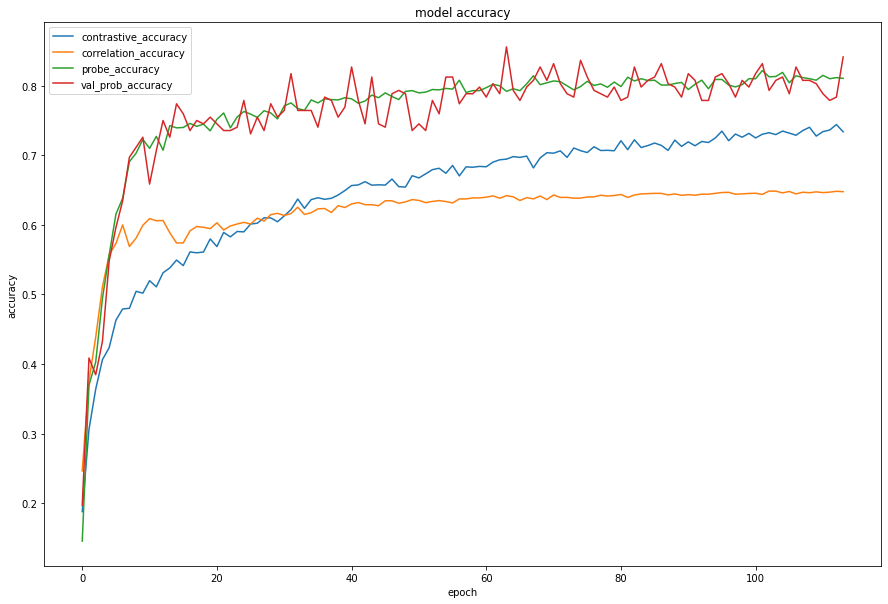

In [22]:
# summarize history for accuracy
plt.figure(figsize=(15, 10))
plt.plot(pretrain_history.history['c_acc'])
plt.plot(pretrain_history.history['r_acc'])
plt.plot(pretrain_history.history['p_acc'])
plt.plot(pretrain_history.history['val_p_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['contrastive_accuracy', 'correlation_accuracy', 'probe_accuracy', 'val_prob_accuracy'], loc='upper left')
plt.savefig('./figures/nnclr_curves_acc.pdf')
plt.show()

## Plot the learned representations


In [23]:
import matplotlib.pyplot as plt
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title

c:\Users\vangelis\miniconda3\envs\tf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


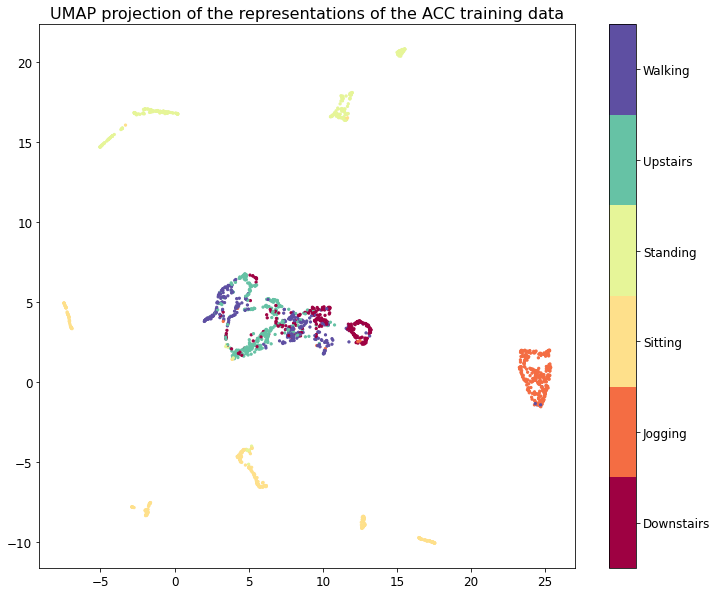

In [24]:
# Plot the representations of the data in the representation space learned by the NNCLR encoder. Use UMAP to reduce the dimensionality to 2. The color of each point corresponds to its label.

import umap.umap_ as umap
import numpy as np

# Get the representations of the  data.
feature_vectors = model_acc.encoder(x_train_acc, training=False)

# Reduce the dimensionality of the representations to 2.
reducer = umap.UMAP()
umap_model = reducer.fit(feature_vectors)
umap_embeddings = umap_model.transform(feature_vectors)

# Plot the representations.
plt.figure(figsize=(12, 10))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=y_train, s=5.0, cmap='Spectral')
# plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the representations of the ACC training data')
cbar = plt.colorbar(boundaries=np.arange(n_classes+1)-0.5)
cbar.set_ticks(np.arange(n_classes))
cbar.set_ticklabels(t_names)

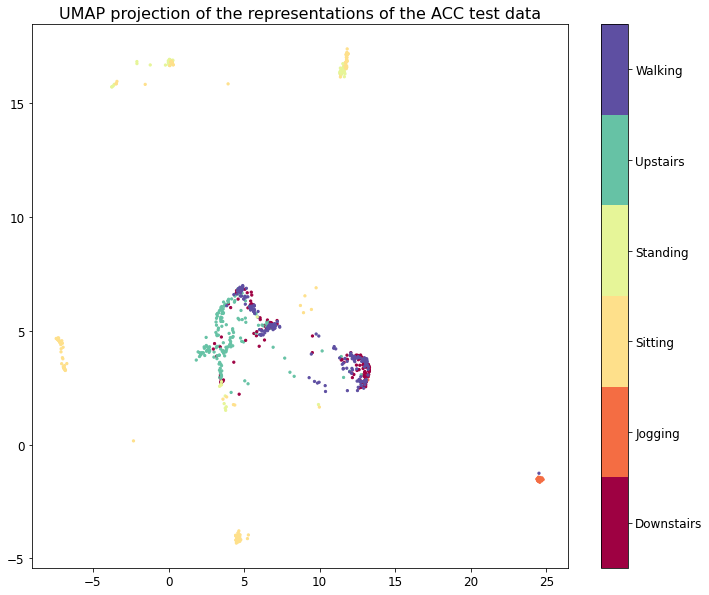

In [25]:
# Get the representations of the data.
feature_vectors = model_acc.encoder(x_test_acc, training=False)

# Reduce the dimensionality of the representations to 2.
reducer = umap.UMAP()
umap_embeddings = umap_model.transform(feature_vectors)

# Plot the representations.
plt.figure(figsize=(12, 10))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=y_test, s=5.0, cmap='Spectral')
# plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar(boundaries=np.arange(n_classes+1)-0.5).set_ticks(np.arange(n_classes))
plt.title('UMAP projection of the representations of the ACC test data')
cbar = plt.colorbar(boundaries=np.arange(n_classes+1)-0.5)
cbar.set_ticks(np.arange(n_classes))
cbar.set_ticklabels(t_names)

## BVP Channel

In [26]:
# Create tf.data.Dataset objects for BVP channel
unlabeled_train_dataset_bvp = tf.data.Dataset.from_tensor_slices((x_unlabeled_bvp, y_unlabeled))
unlabeled_train_dataset_bvp = unlabeled_train_dataset_bvp.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
unlabeled_train_dataset_bvp = unlabeled_train_dataset_bvp.prefetch(AUTOTUNE)

labeled_train_dataset_bvp = tf.data.Dataset.from_tensor_slices((x_train_bvp, y_train))
labeled_train_dataset_bvp = labeled_train_dataset_bvp.batch(BATCH_SIZE)
labeled_train_dataset_bvp = labeled_train_dataset_bvp.prefetch(AUTOTUNE)

valid_dataset_bvp = tf.data.Dataset.from_tensor_slices((x_valid_bvp, y_valid))
valid_dataset_bvp = valid_dataset_bvp.batch(BATCH_SIZE)
valid_dataset_bvp = valid_dataset_bvp.prefetch(AUTOTUNE)

test_dataset_bvp = tf.data.Dataset.from_tensor_slices((x_test_bvp, y_test))
test_dataset_bvp = test_dataset_bvp.batch(BATCH_SIZE)
test_dataset_bvp = test_dataset_bvp.prefetch(AUTOTUNE)

train_dataset_bvp = tf.data.Dataset.zip(
    (unlabeled_train_dataset_bvp, labeled_train_dataset_bvp)
).prefetch(buffer_size=AUTOTUNE)

In [34]:
input_shape_bvp = (x_train_bvp.shape[1], x_train_bvp.shape[2])
output_width = 32
k_size = 16

encoder_bvp = keras.Sequential(
        [
            layers.Input(shape=input_shape_bvp),
            layers.Conv1D(filters=50, kernel_size=33, activation='relu'),
            layers.SpatialDropout1D(0.25),
            layers.Conv1D(filters=50, kernel_size=33, activation='relu'),
            layers.MaxPooling1D(pool_size=12),
            layers.Dropout(0.25),
            
			layers.Flatten(),
            layers.Dense(100, activation='relu'),
			layers.Dense(output_width, activation='relu'),
        ],
        name="encoder_bvp",
    )

In [35]:
model_bvp = NNCLR(temperature=temperature, queue_size=queue_size, input_shape=input_shape_bvp, output_width=output_width, n_classes= n_classes, encoder=encoder_bvp)
model_bvp.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
    run_eagerly=None # True = run eagerly, False = run as graph, None = autodetect
)

model_bvp.build(input_shape=(None, input_shape_bvp[0], input_shape_bvp[1]))
model_bvp.summary()

Model: "nnclr_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 contrastive_augmenter (Sequ  (None, None, 1)          0         
 ential)                                                         
                                                                 
 classification_augmenter (S  (None, None, 1)          0         
 equential)                                                      
                                                                 
 encoder_bvp (Sequential)    (None, 32)                97582     
                                                                 
 projection_head (Sequential  (None, 32)               2112      
 )                                                               
                                                                 
 linear_probe (Sequential)   (None, 6)                 198       
                                                           

In [36]:
EPOCHS = 500
checkpoint_filepath = './tmp/checkpoint_bvp_2'
# Delete old checkpoint files
if os.path.exists(checkpoint_filepath+".index"):
    os.remove(checkpoint_filepath+".index")
    os.remove(checkpoint_filepath+".data-00000-of-00001")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_p_acc',
    mode='max',
    save_best_only=True)

stop_early = keras.callbacks.EarlyStopping(monitor='val_p_acc', patience=500, restore_best_weights=True)
pretrain_history = model_bvp.fit(
    train_dataset_bvp, epochs=EPOCHS, validation_data=valid_dataset_bvp, 
    verbose=2, # 0 = silent, 1 = progress bar, 2 = one line per epoch, 3 = one line per batch
              # Due to a weird bug, the fit function crashes if verbose is set to 1.
    callbacks=[model_checkpoint_callback, stop_early]
)

model_bvp.load_weights(checkpoint_filepath)
model_bvp.save_weights('./saved_models/model1_bvp.h5')

Epoch 1/500
117/117 - 5s - c_loss: 2.2199 - c_acc: 0.2232 - r_acc: 0.2067 - p_loss: 2.8414 - p_acc: 0.1145 - val_p_loss: 3.0269 - val_p_acc: 0.0962 - 5s/epoch - 43ms/step
Epoch 2/500
117/117 - 2s - c_loss: 2.1831 - c_acc: 0.3205 - r_acc: 0.2866 - p_loss: 2.2901 - p_acc: 0.1514 - val_p_loss: 2.7180 - val_p_acc: 0.1250 - 2s/epoch - 14ms/step
Epoch 3/500
117/117 - 2s - c_loss: 1.6551 - c_acc: 0.3867 - r_acc: 0.3295 - p_loss: 2.4346 - p_acc: 0.1573 - val_p_loss: 2.5288 - val_p_acc: 0.2596 - 2s/epoch - 14ms/step
Epoch 4/500
117/117 - 2s - c_loss: 1.8164 - c_acc: 0.4297 - r_acc: 0.4056 - p_loss: 1.8832 - p_acc: 0.2499 - val_p_loss: 2.0724 - val_p_acc: 0.2404 - 2s/epoch - 13ms/step
Epoch 5/500
117/117 - 2s - c_loss: 1.3237 - c_acc: 0.4770 - r_acc: 0.4221 - p_loss: 1.9656 - p_acc: 0.3060 - val_p_loss: 1.7080 - val_p_acc: 0.3750 - 2s/epoch - 14ms/step
Epoch 6/500
117/117 - 2s - c_loss: 1.4398 - c_acc: 0.5004 - r_acc: 0.4626 - p_loss: 1.8977 - p_acc: 0.3317 - val_p_loss: 1.4885 - val_p_acc: 0.39

In [37]:
model_bvp.load_weights('./saved_models/model1_bvp.h5')

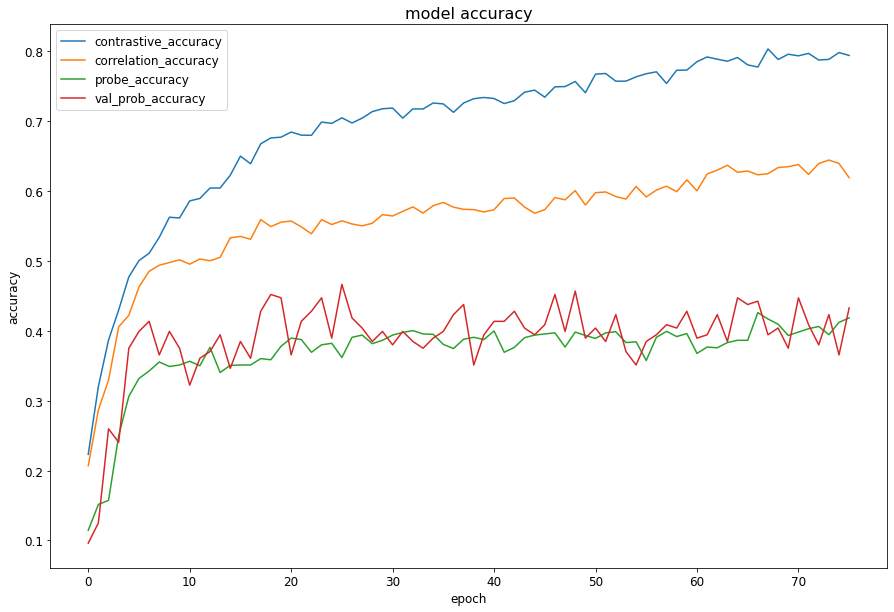

In [38]:
# summarize history for accuracy
plt.figure(figsize=(15, 10))
plt.plot(pretrain_history.history['c_acc'])
plt.plot(pretrain_history.history['r_acc'])
plt.plot(pretrain_history.history['p_acc'])
plt.plot(pretrain_history.history['val_p_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['contrastive_accuracy', 'correlation_accuracy', 'probe_accuracy', 'val_prob_accuracy'], loc='upper left')
plt.savefig('./figures/nnclr_curves_bvp.pdf')
plt.show()

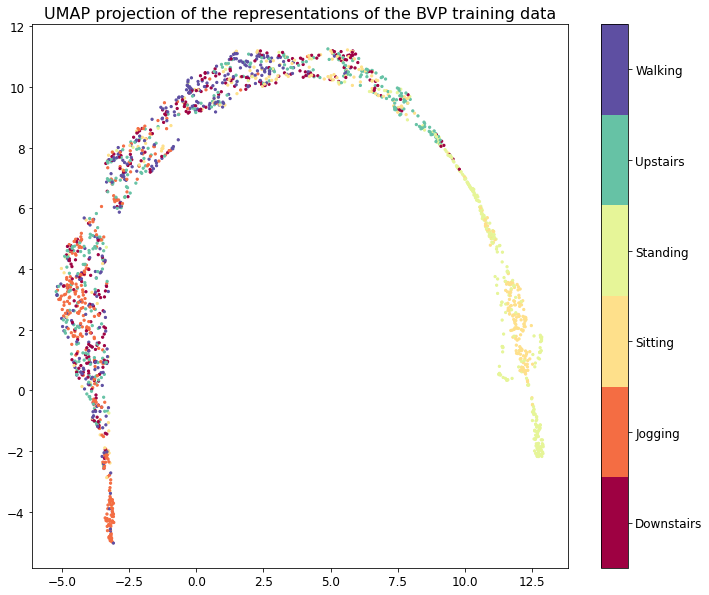

In [39]:
# Get the representations of the data.
feature_vectors = model_bvp.encoder(x_train_bvp, training=False)

# Reduce the dimensionality of the representations to 2.
reducer = umap.UMAP()
umap_model = reducer.fit(feature_vectors)
umap_embeddings = umap_model.transform(feature_vectors)

# Plot the representations.
plt.figure(figsize=(12, 10))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=y_train, s=5.0, cmap='Spectral')
# plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar(boundaries=np.arange(n_classes+1)-0.5).set_ticks(np.arange(n_classes))
plt.title('UMAP projection of the representations of the BVP training data')
cbar = plt.colorbar(boundaries=np.arange(n_classes+1)-0.5)
cbar.set_ticks(np.arange(n_classes))
cbar.set_ticklabels(t_names)

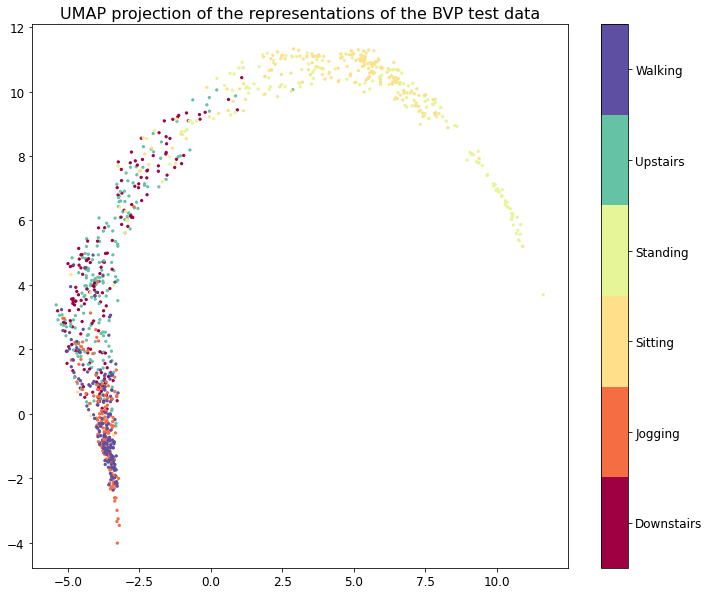

In [40]:
# Get the representations of the data.
feature_vectors = model_bvp.encoder(x_test_bvp, training=False)

# Reduce the dimensionality of the representations to 2.
umap_embeddings = umap_model.transform(feature_vectors)

# Plot the representations.
plt.figure(figsize=(12, 10))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=y_test, s=5.0, cmap='Spectral')
# plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar(boundaries=np.arange(n_classes+1)-0.5).set_ticks(np.arange(n_classes))
plt.title('UMAP projection of the representations of the BVP test data')
cbar = plt.colorbar(boundaries=np.arange(n_classes+1)-0.5)
cbar.set_ticks(np.arange(n_classes))
cbar.set_ticklabels(t_names)

## EDA Channel

In [41]:
# Create tf.data.Dataset objects for EDA channel
unlabeled_train_dataset_eda = tf.data.Dataset.from_tensor_slices((x_unlabeled_eda, y_unlabeled))
unlabeled_train_dataset_eda = unlabeled_train_dataset_eda.batch(BATCH_SIZE)
unlabeled_train_dataset_eda = unlabeled_train_dataset_eda.prefetch(AUTOTUNE)

labeled_train_dataset_eda = tf.data.Dataset.from_tensor_slices((x_train_eda, y_train))
labeled_train_dataset_eda = labeled_train_dataset_eda.batch(BATCH_SIZE)
labeled_train_dataset_eda = labeled_train_dataset_eda.prefetch(AUTOTUNE)

valid_dataset_eda = tf.data.Dataset.from_tensor_slices((x_valid_eda, y_valid))
valid_dataset_eda = valid_dataset_eda.batch(BATCH_SIZE)
valid_dataset_eda = valid_dataset_eda.prefetch(AUTOTUNE)

test_dataset_eda = tf.data.Dataset.from_tensor_slices((x_test_eda, y_test))
test_dataset_eda = test_dataset_eda.batch(BATCH_SIZE)
test_dataset_eda = test_dataset_eda.prefetch(AUTOTUNE)

train_dataset_eda = tf.data.Dataset.zip(
    (unlabeled_train_dataset_eda, labeled_train_dataset_eda)
)

In [45]:
input_shape_eda = (x_train_eda.shape[1], x_train_eda.shape[2])
output_width = 32

encoder_eda = keras.Sequential(
        [
            layers.Input(shape=input_shape_eda),
            layers.Conv1D(filters=50, kernel_size=33, activation='relu'),
            layers.SpatialDropout1D(0.25),
            layers.Conv1D(filters=50, kernel_size=33, activation='relu'),
            layers.MaxPooling1D(pool_size=12),
            layers.Dropout(0.25),
            
			layers.Flatten(),
            layers.Dense(100, activation='relu'),
			layers.Dense(output_width, activation='relu'),
        ],
        name="encoder_eda",
    )

In [46]:
model_eda = NNCLR(temperature=temperature, queue_size=queue_size, input_shape=input_shape_eda, output_width=output_width, n_classes= n_classes, encoder=encoder_eda)
model_eda.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
    run_eagerly=None # True = run eagerly, False = run as graph, None = autodetect
)

model_eda.build(input_shape=(None, input_shape_eda[0], input_shape_eda[1]))
model_eda.summary()

Model: "nnclr_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 contrastive_augmenter (Sequ  (None, None, 1)          0         
 ential)                                                         
                                                                 
 classification_augmenter (S  (None, None, 1)          0         
 equential)                                                      
                                                                 
 encoder_eda (Sequential)    (None, 32)                97582     
                                                                 
 projection_head (Sequential  (None, 32)               2112      
 )                                                               
                                                                 
 linear_probe (Sequential)   (None, 6)                 198       
                                                           

In [47]:
EPOCHS = 100
checkpoint_filepath = './tmp/checkpoint_eda_2'
# Delete old checkpoint files
if os.path.exists(checkpoint_filepath+".index"):
    os.remove(checkpoint_filepath+".index")
    os.remove(checkpoint_filepath+".data-00000-of-00001")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_p_acc',
    mode='max',
    save_best_only=True)

stop_early = keras.callbacks.EarlyStopping(monitor='val_p_acc', patience=100, restore_best_weights=True)
pretrain_history = model_eda.fit(
    train_dataset_eda, epochs=EPOCHS, validation_data=valid_dataset_eda, 
    verbose=2, # 0 = silent, 1 = progress bar, 2 = one line per epoch, 3 = one line per batch
              # Due to a weird bug, the fit function crashes if verbose is set to 1.
    callbacks=[model_checkpoint_callback, stop_early]
)

model_eda.load_weights(checkpoint_filepath)
model_eda.save_weights('./saved_models/model1_eda.h5')

Epoch 1/100
117/117 - 5s - c_loss: 2.3476 - c_acc: 0.0730 - r_acc: 0.0735 - p_loss: 1.8819 - p_acc: 0.1616 - val_p_loss: 1.9607 - val_p_acc: 0.1010 - 5s/epoch - 44ms/step
Epoch 2/100
117/117 - 2s - c_loss: 2.3745 - c_acc: 0.1369 - r_acc: 0.1482 - p_loss: 1.8566 - p_acc: 0.1332 - val_p_loss: 1.7667 - val_p_acc: 0.1923 - 2s/epoch - 14ms/step
Epoch 3/100
117/117 - 2s - c_loss: 2.2361 - c_acc: 0.1395 - r_acc: 0.1494 - p_loss: 1.8086 - p_acc: 0.1990 - val_p_loss: 1.7516 - val_p_acc: 0.2500 - 2s/epoch - 14ms/step
Epoch 4/100
117/117 - 2s - c_loss: 2.2770 - c_acc: 0.1490 - r_acc: 0.1588 - p_loss: 1.7872 - p_acc: 0.2081 - val_p_loss: 1.7165 - val_p_acc: 0.2356 - 2s/epoch - 13ms/step
Epoch 5/100
117/117 - 2s - c_loss: 2.3456 - c_acc: 0.1589 - r_acc: 0.1653 - p_loss: 1.7475 - p_acc: 0.2269 - val_p_loss: 1.6628 - val_p_acc: 0.2163 - 2s/epoch - 13ms/step
Epoch 6/100
117/117 - 2s - c_loss: 2.2870 - c_acc: 0.1609 - r_acc: 0.1532 - p_loss: 1.7179 - p_acc: 0.2194 - val_p_loss: 1.6436 - val_p_acc: 0.24

In [48]:
model_eda.load_weights('./saved_models/model1_eda.h5')

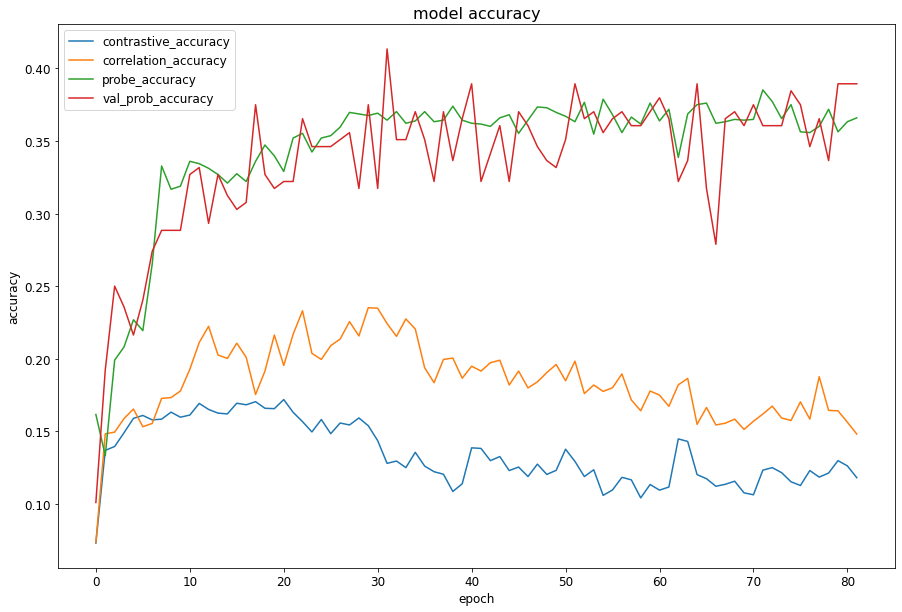

In [49]:
# summarize history for accuracy
plt.figure(figsize=(15, 10))
plt.plot(pretrain_history.history['c_acc'])
plt.plot(pretrain_history.history['r_acc'])
plt.plot(pretrain_history.history['p_acc'])
plt.plot(pretrain_history.history['val_p_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['contrastive_accuracy', 'correlation_accuracy', 'probe_accuracy', 'val_prob_accuracy'], loc='upper left')
plt.savefig('./figures/nnclr_curves_eda.pdf')
plt.show()

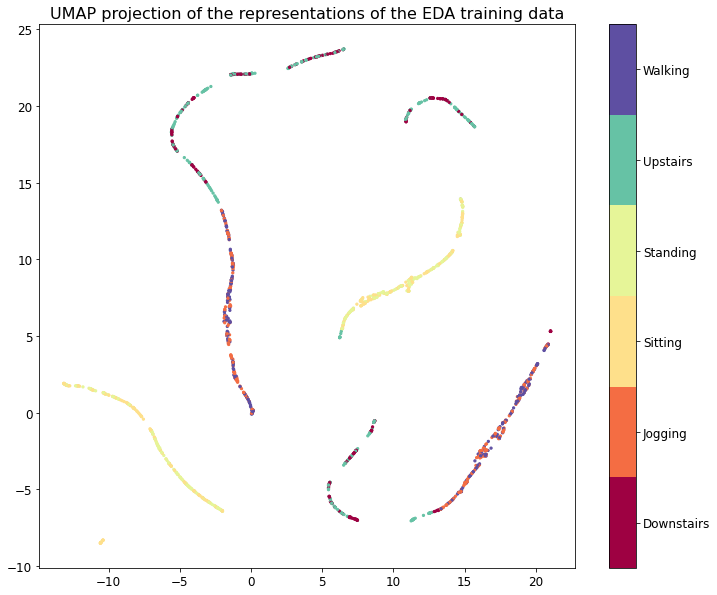

In [50]:
# Get the representations of the data.
feature_vectors = model_eda.encoder(x_train_eda, training=False)

# Reduce the dimensionality of the representations to 2.
reducer = umap.UMAP()
umap_model = reducer.fit(feature_vectors)
umap_embeddings = umap_model.transform(feature_vectors)

# Plot the representations.
plt.figure(figsize=(12, 10))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=y_train, s=5.0, cmap='Spectral')
# plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar(boundaries=np.arange(n_classes+1)-0.5).set_ticks(np.arange(n_classes))
plt.title('UMAP projection of the representations of the EDA training data')
cbar = plt.colorbar(boundaries=np.arange(n_classes+1)-0.5)
cbar.set_ticks(np.arange(n_classes))
cbar.set_ticklabels(t_names)

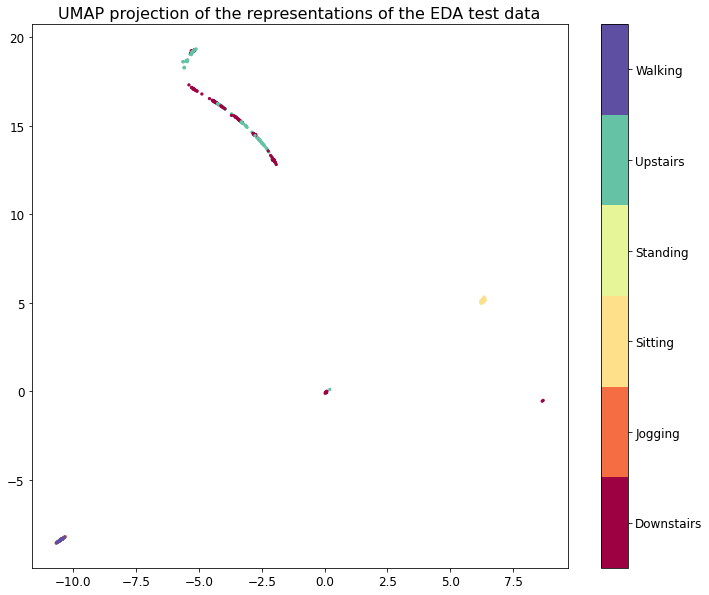

In [51]:
# Get the representations of the data.
feature_vectors = model_eda.encoder(x_test_eda, training=False)

# Reduce the dimensionality of the representations to 2.
reducer = umap.UMAP()
umap_embeddings = umap_model.transform(feature_vectors)

# Plot the representations.
plt.figure(figsize=(12, 10))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=y_test, s=5.0, cmap='Spectral')
# plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar(boundaries=np.arange(n_classes+1)-0.5).set_ticks(np.arange(n_classes))
plt.title('UMAP projection of the representations of the EDA test data')
cbar = plt.colorbar(boundaries=np.arange(n_classes+1)-0.5)
cbar.set_ticks(np.arange(n_classes))
cbar.set_ticklabels(t_names)

## TEMP Channel

In [52]:
# Create tf.data.Dataset objects for temp channel
unlabeled_train_dataset_temp = tf.data.Dataset.from_tensor_slices((x_unlabeled_temp, y_unlabeled))
unlabeled_train_dataset_temp = unlabeled_train_dataset_temp.batch(BATCH_SIZE)
unlabeled_train_dataset_temp = unlabeled_train_dataset_temp.prefetch(AUTOTUNE)

labeled_train_dataset_temp = tf.data.Dataset.from_tensor_slices((x_train_temp, y_train))
labeled_train_dataset_temp = labeled_train_dataset_temp.batch(BATCH_SIZE)
labeled_train_dataset_temp = labeled_train_dataset_temp.prefetch(AUTOTUNE)

valid_dataset_temp = tf.data.Dataset.from_tensor_slices((x_valid_temp, y_valid))
valid_dataset_temp = valid_dataset_temp.batch(BATCH_SIZE)
valid_dataset_temp = valid_dataset_temp.prefetch(AUTOTUNE)

test_dataset_temp = tf.data.Dataset.from_tensor_slices((x_test_temp, y_test))
test_dataset_temp = test_dataset_temp.batch(BATCH_SIZE)
test_dataset_temp = test_dataset_temp.prefetch(AUTOTUNE)

train_dataset_temp = tf.data.Dataset.zip(
    (unlabeled_train_dataset_temp, labeled_train_dataset_temp)
)

In [53]:
input_shape_temp = (x_train_temp.shape[1], x_train_temp.shape[2])
output_width = 32

encoder_temp = keras.Sequential(
        [
            layers.Input(shape=input_shape_temp),
            layers.Conv1D(filters=50, kernel_size=33, activation='relu'),
            layers.SpatialDropout1D(0.25),
            layers.Conv1D(filters=50, kernel_size=33, activation='relu'),
            layers.MaxPooling1D(pool_size=12),
            layers.Dropout(0.25),
            
			layers.Flatten(),
            layers.Dense(100, activation='relu'),
			layers.Dense(output_width, activation='relu'),
        ],
        name="encoder_temp",
    )

In [54]:
model_temp = NNCLR(temperature=temperature, queue_size=queue_size, input_shape=input_shape_temp, output_width=output_width, n_classes= n_classes, encoder=encoder_temp)
model_temp.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
    run_eagerly=None # True = run eagerly, False = run as graph, None = autodetect
)

model_temp.build(input_shape=(None, input_shape_temp[0], input_shape_temp[1]))
model_temp.summary()

Model: "nnclr_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 contrastive_augmenter (Sequ  (None, None, 1)          0         
 ential)                                                         
                                                                 
 classification_augmenter (S  (None, None, 1)          0         
 equential)                                                      
                                                                 
 encoder_temp (Sequential)   (None, 32)                97582     
                                                                 
 projection_head (Sequential  (None, 32)               2112      
 )                                                               
                                                                 
 linear_probe (Sequential)   (None, 6)                 198       
                                                           

In [55]:
EPOCHS = 100
checkpoint_filepath = './tmp/checkpoint_temp_2'
# Delete old checkpoint files
if os.path.exists(checkpoint_filepath+".index"):
    os.remove(checkpoint_filepath+".index")
    os.remove(checkpoint_filepath+".data-00000-of-00001")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_p_acc',
    mode='max',
    save_best_only=True)

stop_early = keras.callbacks.EarlyStopping(monitor='val_p_acc', patience=100, restore_best_weights=True)
pretrain_history = model_temp.fit(
    train_dataset_temp, epochs=EPOCHS, validation_data=valid_dataset_temp, 
    verbose=2, # 0 = silent, 1 = progress bar, 2 = one line per epoch, 3 = one line per batch
              # Due to a weird bug, the fit function crashes if verbose is set to 1.
    callbacks=[model_checkpoint_callback, stop_early]
)

model_temp.load_weights(checkpoint_filepath)
model_temp.save_weights('./saved_models/model1_temp.h5')

Epoch 1/100
117/117 - 5s - c_loss: 3.3689 - c_acc: 0.0326 - r_acc: 0.0620 - p_loss: 1.9690 - p_acc: 0.1659 - val_p_loss: 1.7954 - val_p_acc: 0.1635 - 5s/epoch - 41ms/step
Epoch 2/100
117/117 - 2s - c_loss: 3.3677 - c_acc: 0.0314 - r_acc: 0.0656 - p_loss: 1.8099 - p_acc: 0.1712 - val_p_loss: 1.8999 - val_p_acc: 0.1635 - 2s/epoch - 14ms/step
Epoch 3/100
117/117 - 2s - c_loss: 3.3679 - c_acc: 0.0315 - r_acc: 0.0641 - p_loss: 1.9463 - p_acc: 0.1653 - val_p_loss: 1.8468 - val_p_acc: 0.1490 - 2s/epoch - 13ms/step
Epoch 4/100
117/117 - 1s - c_loss: 3.3671 - c_acc: 0.0321 - r_acc: 0.0616 - p_loss: 1.8837 - p_acc: 0.1637 - val_p_loss: 1.8065 - val_p_acc: 0.1298 - 1s/epoch - 13ms/step
Epoch 5/100
117/117 - 2s - c_loss: 3.3664 - c_acc: 0.0317 - r_acc: 0.0613 - p_loss: 1.9313 - p_acc: 0.1637 - val_p_loss: 1.8580 - val_p_acc: 0.1538 - 2s/epoch - 13ms/step
Epoch 6/100
117/117 - 1s - c_loss: 3.3664 - c_acc: 0.0273 - r_acc: 0.0648 - p_loss: 1.8526 - p_acc: 0.1514 - val_p_loss: 1.8981 - val_p_acc: 0.13

In [56]:
model_temp.load_weights('./saved_models/model1_temp.h5')

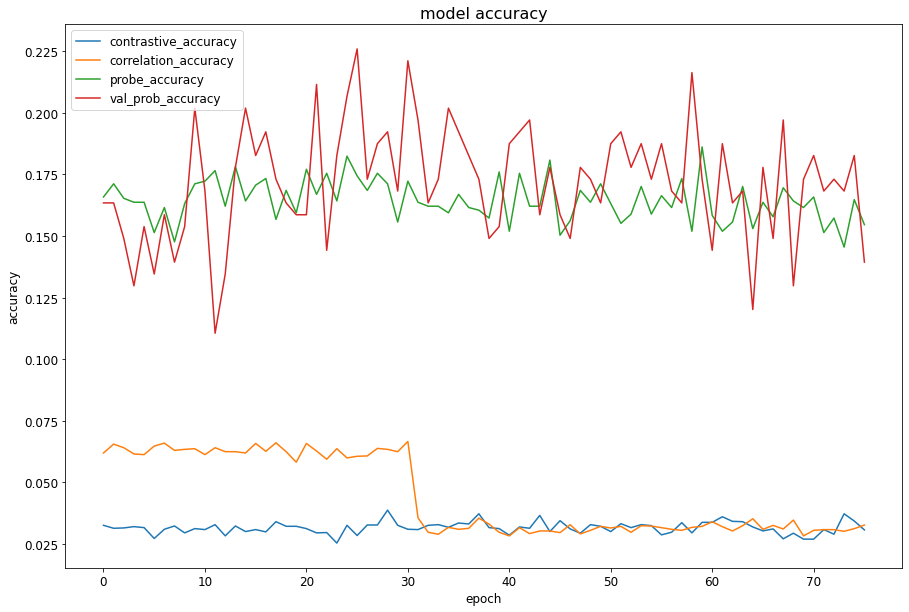

In [57]:
# summarize history for accuracy
plt.figure(figsize=(15, 10))
plt.plot(pretrain_history.history['c_acc'])
plt.plot(pretrain_history.history['r_acc'])
plt.plot(pretrain_history.history['p_acc'])
plt.plot(pretrain_history.history['val_p_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['contrastive_accuracy', 'correlation_accuracy', 'probe_accuracy', 'val_prob_accuracy'], loc='upper left')
plt.savefig('./figures/nnclr_curves_temp.pdf')
plt.show()

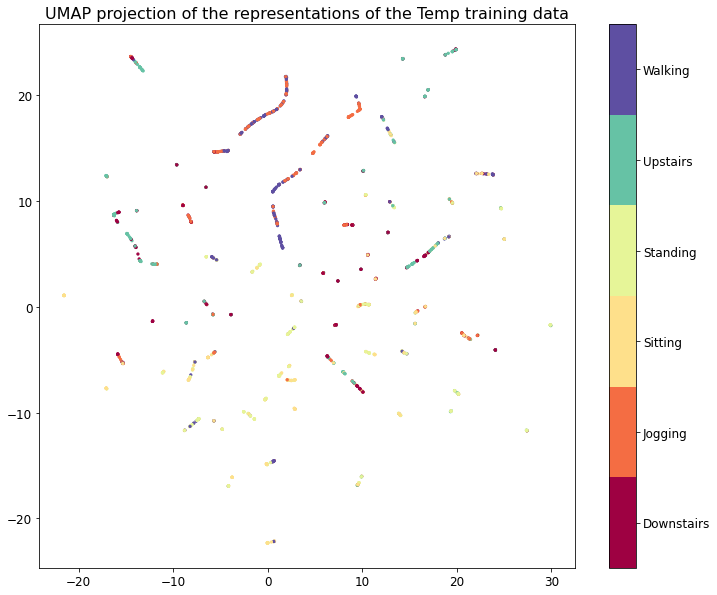

In [58]:
feature_vectors = model_temp.encoder(x_train_temp, training=False)

# Reduce the dimensionality of the representations to 2.
reducer = umap.UMAP()
umap_model = reducer.fit(feature_vectors)
umap_embeddings = umap_model.transform(feature_vectors)

# Plot the representations.
plt.figure(figsize=(12, 10))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=y_train, s=5.0, cmap='Spectral')
# plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar(boundaries=np.arange(n_classes+1)-0.5).set_ticks(np.arange(n_classes))
plt.title('UMAP projection of the representations of the Temp training data')
cbar = plt.colorbar(boundaries=np.arange(n_classes+1)-0.5)
cbar.set_ticks(np.arange(n_classes))
cbar.set_ticklabels(t_names)

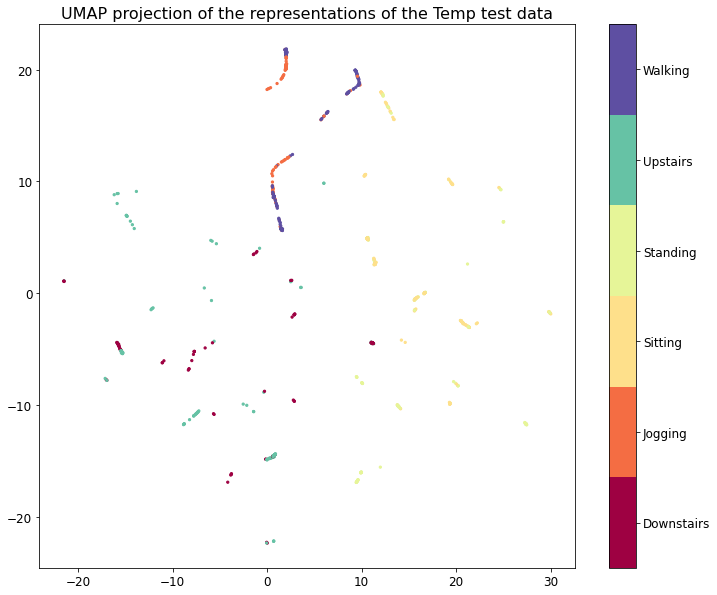

In [59]:
feature_vectors = model_temp.encoder(x_test_temp, training=False)

# Reduce the dimensionality of the representations to 2.
umap_embeddings = umap_model.transform(feature_vectors)

# Plot the representations.
plt.figure(figsize=(12, 10))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=y_test, s=5.0, cmap='Spectral')
# plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar(boundaries=np.arange(n_classes+1)-0.5).set_ticks(np.arange(n_classes))
plt.title('UMAP projection of the representations of the Temp test data')
cbar = plt.colorbar(boundaries=np.arange(n_classes+1)-0.5)
cbar.set_ticks(np.arange(n_classes))
cbar.set_ticklabels(t_names)

## Fine tune the model

### Run a stratified 5-fold group-based cross validation on the x_labeled data

In [66]:
def get_fusion_model():
    acc_input = keras.Input(shape = (x_train_acc.shape[1], x_train_acc.shape[2]), name = "acc")
    bvp_input = keras.Input(shape = (x_train_bvp.shape[1], x_train_bvp.shape[2]), name = "bvp")
    # eda_input = keras.Input(shape = (x_train_eda.shape[1], x_train_eda.shape[2]), name = "eda")
    # temp_input = keras.Input(shape = (x_train_temp.shape[1], x_train_temp.shape[2]), name = "temp")

    acc_augmenter_output = augmenter("acc_classification_augmenter", input_shape=input_shape_acc)(acc_input)
    bvp_augmenter_output = augmenter("bvp_classification_augmenter", input_shape=input_shape_bvp)(bvp_input)
    # eda_augmenter_output = augmenter("eda_classification_augmenter", input_shape=input_shape_eda)(eda_input)
    # temp_augmenter_output = augmenter("temp_classification_augmenter", input_shape=input_shape_temp)(temp_input)

    model_acc.load_weights("./saved_models/model1_acc.h5")
    model_bvp.load_weights("./saved_models/model1_bvp.h5")
    # model_eda.load_weights("./saved_models/model1_eda.h5")
    # model_temp.load_weights("./saved_models/model1_temp.h5")
    acc_encoder_output = model_acc.encoder(acc_augmenter_output)
    bvp_encoder_output = model_bvp.encoder(bvp_augmenter_output)
    # eda_encoder_output = model_eda.encoder(eda_augmenter_output)
    # temp_encoder_output = model_temp.encoder(temp_augmenter_output)

    # Add a third dimension to the tensor. Required by the attention layer.
    acc_encoder_output = tf.expand_dims(acc_encoder_output, 2)
    bvp_encoder_output = tf.expand_dims(bvp_encoder_output, 2)
    # eda_encoder_output = tf.expand_dims(eda_encoder_output, 2)
    # temp_encoder_output = tf.expand_dims(temp_encoder_output, 2)

    # Concatenate the outputs of the two encoders
    # concatenated = layers.Concatenate(axis=1)([acc_encoder_output, bvp_encoder_output, eda_encoder_output, temp_encoder_output])
    concatenated = layers.Concatenate(axis=1)([acc_encoder_output, bvp_encoder_output])

    # Add a attention layer
    # concatenated = Attention(concatenated.shape[1])(concatenated)   # Regular attention layer.

    concatenated = layers.Flatten()(concatenated)

    # Add a Dense layer with a Relu activation
    concatenated = layers.Dense(64, activation="relu")(concatenated)

    # Add a softmax classifier on top
    output = layers.Dense(n_classes, activation="softmax", name="output")(concatenated)

    finetuning_model = keras.Model(
        # inputs=[acc_input, bvp_input, eda_input, temp_input],
        inputs=[acc_input, bvp_input],
        outputs=output,
        name="finetuning_model",
    )


    finetuning_model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
        run_eagerly=None # True = run eagerly, False = run as graph, None = autodetect
    )

    # print(finetuning_model.summary())

    return finetuning_model

Fold 0:
Epoch 1/200
67/67 [==============================] - 4s 25ms/step - loss: 2.8223 - acc: 0.4322 - val_loss: 1.5606 - val_acc: 0.5447
Epoch 2/200
67/67 [==============================] - 1s 14ms/step - loss: 0.8948 - acc: 0.6548 - val_loss: 1.1715 - val_acc: 0.5641
Epoch 3/200
67/67 [==============================] - 1s 13ms/step - loss: 0.6822 - acc: 0.7334 - val_loss: 0.9314 - val_acc: 0.6573
Epoch 4/200
67/67 [==============================] - 1s 13ms/step - loss: 0.6102 - acc: 0.7558 - val_loss: 0.9369 - val_acc: 0.6078
Epoch 5/200
67/67 [==============================] - 1s 14ms/step - loss: 0.5752 - acc: 0.7755 - val_loss: 0.7271 - val_acc: 0.7039
Epoch 6/200
67/67 [==============================] - 1s 14ms/step - loss: 0.5430 - acc: 0.7778 - val_loss: 0.7733 - val_acc: 0.6583
Epoch 7/200
67/67 [==============================] - 1s 13ms/step - loss: 0.5240 - acc: 0.7848 - val_loss: 0.8778 - val_acc: 0.6330
Epoch 8/200
67/67 [==============================] - 1s 14ms/step - 

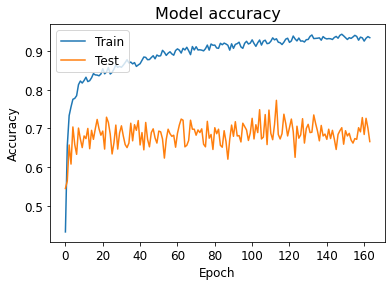

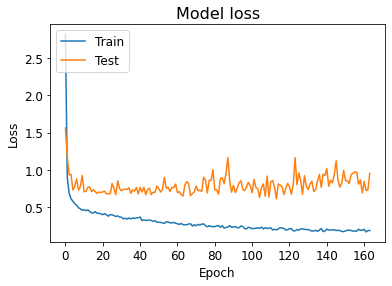

Fold 1:
Epoch 1/200
65/65 [==============================] - 4s 26ms/step - loss: 2.9044 - acc: 0.3881 - val_loss: 1.5024 - val_acc: 0.4262
Epoch 2/200
65/65 [==============================] - 1s 14ms/step - loss: 0.9178 - acc: 0.6548 - val_loss: 1.2904 - val_acc: 0.5151
Epoch 3/200
65/65 [==============================] - 1s 14ms/step - loss: 0.6886 - acc: 0.7318 - val_loss: 0.9812 - val_acc: 0.5307
Epoch 4/200
65/65 [==============================] - 1s 14ms/step - loss: 0.6179 - acc: 0.7472 - val_loss: 1.0425 - val_acc: 0.5646
Epoch 5/200
65/65 [==============================] - 1s 14ms/step - loss: 0.5773 - acc: 0.7583 - val_loss: 0.8681 - val_acc: 0.5967
Epoch 6/200
65/65 [==============================] - 1s 14ms/step - loss: 0.5521 - acc: 0.7819 - val_loss: 0.9790 - val_acc: 0.5408
Epoch 7/200
65/65 [==============================] - 1s 15ms/step - loss: 0.5081 - acc: 0.7944 - val_loss: 0.7787 - val_acc: 0.6169
Epoch 8/200
65/65 [==============================] - 1s 14ms/step - 

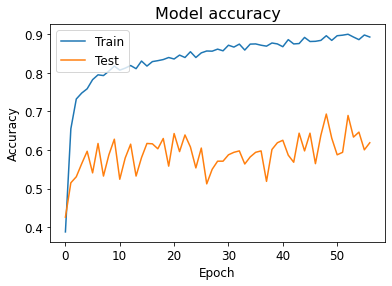

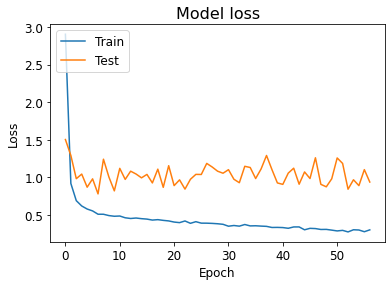

Fold 2:
Epoch 1/200
67/67 [==============================] - 4s 26ms/step - loss: 3.4684 - acc: 0.4455 - val_loss: 1.3176 - val_acc: 0.5005
Epoch 2/200
67/67 [==============================] - 1s 14ms/step - loss: 0.8226 - acc: 0.6601 - val_loss: 1.2603 - val_acc: 0.5817
Epoch 3/200
67/67 [==============================] - 1s 14ms/step - loss: 0.6575 - acc: 0.7214 - val_loss: 1.3369 - val_acc: 0.6036
Epoch 4/200
67/67 [==============================] - 1s 14ms/step - loss: 0.6022 - acc: 0.7454 - val_loss: 1.2803 - val_acc: 0.6304
Epoch 5/200
67/67 [==============================] - 1s 14ms/step - loss: 0.5530 - acc: 0.7619 - val_loss: 1.1712 - val_acc: 0.6294
Epoch 6/200
67/67 [==============================] - 1s 17ms/step - loss: 0.5513 - acc: 0.7600 - val_loss: 0.9488 - val_acc: 0.7182
Epoch 7/200
67/67 [==============================] - 1s 19ms/step - loss: 0.5230 - acc: 0.7784 - val_loss: 0.9828 - val_acc: 0.6648
Epoch 8/200
67/67 [==============================] - 1s 21ms/step - 

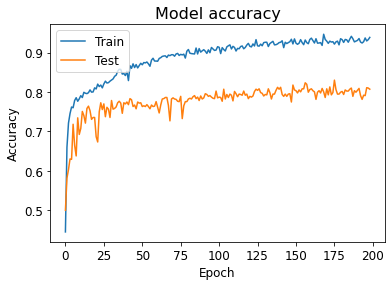

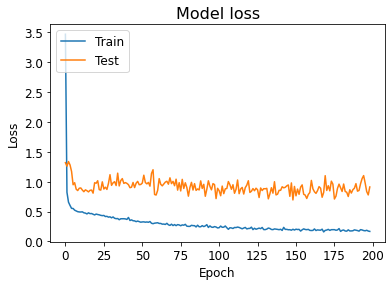

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.6181821823120117 - Accuracy: 77.37864255905151%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.7652732729911804 - Accuracy: 61.50320768356323%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.7083200216293335 - Accuracy: 81.08882308006287%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 73.32355777422588 (+- 8.494385089535879)
> Loss: 0.6972584923108419
------------------------------------------------------------------------


In [67]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import GroupShuffleSplit
import sys

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
y_pred_per_fold = []
y_test_per_fold = []

skf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)

for i, (train_index, test_index) in enumerate(skf.split(x_labeled, y_labeled, groups=sub_labeled)):
    print(f"Fold {i}:")
    # print(f"  Train: index={train_index}")
    # print(f"  Test:  index={test_index}")
    # print(f"  Groups:   index={sub_labeled[test_index]}")


    x_train_acc, x_train_bvp, x_train_eda, x_train_temp = x_labeled_acc[train_index], x_labeled_bvp[train_index], x_labeled_eda[train_index], x_labeled_temp[train_index]
    x_test_acc, x_test_bvp, x_test_eda, x_test_temp = x_labeled_acc[test_index], x_labeled_bvp[test_index], x_labeled_eda[test_index], x_labeled_temp[test_index]
    y_train, y_test = y_labeled[train_index], y_labeled[test_index]

    # # Do a train/validation group-based split
    # gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=42)
    # split_out = gss.split(x_train_acc, y_train, groups=sub_labeled[train_index])
    # train_index_nested, val_index = next(split_out)

    # x_train_acc_nested, x_valid_acc = x_train_acc[train_index_nested], x_train_acc[val_index]
    # x_train_bvp_nested, x_valid_bvp = x_train_bvp[train_index_nested], x_train_bvp[val_index]
    # x_train_eda_nested, x_valid_eda = x_train_eda[train_index_nested], x_train_eda[val_index]
    # x_train_temp_nested, x_valid_temp = x_train_temp[train_index_nested], x_train_temp[val_index]
    # y_train_nested, y_valid = y_train[train_index_nested], y_train[val_index]

    finetuning_model_cv = get_fusion_model()

    stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

    EPOCHS = 200
    finetuning_history = finetuning_model_cv.fit(
        # [x_train_acc, x_train_bvp, x_train_eda, x_train_temp], y_train, epochs=EPOCHS, validation_data=([x_test_acc, x_test_bvp, x_test_eda, x_test_temp], y_test), callbacks=[stop_early]
        [x_train_acc, x_train_bvp], y_train, epochs=EPOCHS, validation_data=([x_test_acc, x_test_bvp], y_test), callbacks=[stop_early]
    )

    # Generate generalization metrics
    # scores = finetuning_model_cv.evaluate([x_test_acc, x_test_bvp, x_test_eda, x_test_temp], y_test, verbose=0)
    scores = finetuning_model_cv.evaluate([x_test_acc, x_test_bvp], y_test, verbose=0)
    print(f"  Test loss: {scores[0]}")
    print(f"  Test accuracy: {scores[1]}")
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Generate predictions
    # y_pred = finetuning_model_cv.predict([x_test_acc, x_test_bvp, x_test_eda, x_test_temp])
    y_pred = finetuning_model_cv.predict([x_test_acc, x_test_bvp])
    y_pred = np.argmax(y_pred, axis=1)
    y_pred_per_fold.append(y_pred)
    y_test_per_fold.append(y_test)

    # Plot training & validation accuracy values
    plt.plot(finetuning_history.history['acc'])
    plt.plot(finetuning_history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(finetuning_history.history['loss'])
    plt.plot(finetuning_history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


Confusion matrix, without normalization
[[339   0   1   8  55  87]
 [  2 508   0   0   2   8]
 [  0   0 446  39   3  36]
 [  0   0  18 478  14  18]
 [ 64   1   1   2 407  93]
 [247  20   6   0 122 143]]
              precision    recall  f1-score   support

  Downstairs       0.52      0.69      0.59       490
     Jogging       0.96      0.98      0.97       520
     Sitting       0.94      0.85      0.90       524
    Standing       0.91      0.91      0.91       528
    Upstairs       0.67      0.72      0.70       568
     Walking       0.37      0.27      0.31       538

    accuracy                           0.73      3168
   macro avg       0.73      0.73      0.73      3168
weighted avg       0.73      0.73      0.73      3168



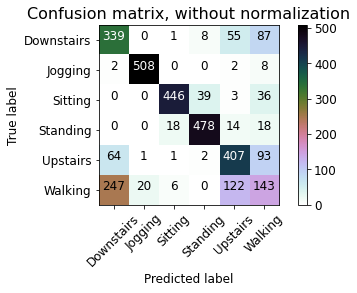

In [68]:
# == Confusion matrix ==
from sklearn.metrics import confusion_matrix
import itertools

y_pred = np.concatenate(y_pred_per_fold)
y_test = np.concatenate(y_test_per_fold)

cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')
    
        print(cm)
    
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
    
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

plot_confusion_matrix(cm, classes=t_names, title='Confusion matrix, without normalization', cmap='cubehelix_r')
print(classification_report(y_test, y_pred, target_names=t_names))